In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from collections import deque

from controllers.game_controller import GameController
from drl.agent import DRLAgent
from models.players.random_player import RandomPlayer
from models.players.drl_player import DRLPlayer
from utils import get_reward_from_winner

In [3]:
def run_validation(drl_players, n_episodes_validation):
    game_controller = GameController()
    players = [
        drl_players[0],
        RandomPlayer(1)
    ]
    game_controller.load_validation(players)
    
    # Disable train mode
    players[0].train_mode = False

    validation_scores = []
    for i in range(1, n_episodes_validation+1):
        episode_winner = game_controller.run_episode(eval_mode=True)
        validation_score = get_reward_from_winner(0, episode_winner)
        validation_scores.append(validation_score)
        game_controller.game.reset()

    # Re-enable train mode
    players[0].train_mode = True
    
    return np.mean(validation_scores)

In [12]:
def init_train(game_controller, drl_players, model_path=None, 
                                eps_start=1.0, eps_end=0.01, eps_decay=0.9999, start_epoch=1):
        n_episodes = 10000
        checkpoint_each = 100
        validate_each = 10
        n_episodes_validation = 10
        train_args = {
            'eps': eps_start,
            'eps_end': eps_end,
            'eps_decay': eps_decay
        }
        
        game_controller.load_train(drl_players)
        for player in range(2):
            drl_players[player].update_epsilon(eps_start)

        winners = []
        try:
            validation_scores = []
            validation_scores_window = deque(maxlen=100)
            start = time.time()
            for i in range(start_epoch, start_epoch+n_episodes):
                episode_winner = game_controller.run_episode(train_mode=True, train_args=train_args)
                winners.append(episode_winner)
                game_controller.game.reset()

                if i%validate_each == 0:
                    mean_validation_score = run_validation(drl_players, n_episodes_validation)

                    validation_scores.append(mean_validation_score)
                    validation_scores_window.append(mean_validation_score)
                    mean_validation_score_last_runs = np.mean(validation_scores_window)

                    print("\rEpisode #{:4d}  |  "
                        "Val. Score: {:+5.2f}  |  "
                        "Avg. Val. Score: {:+5.2f}  |  "
                        "Epsilon: {:5.3f}  |  "
                        "Time elapsed: {:.2f}s".format(i, mean_validation_score,
                                            mean_validation_score_last_runs, train_args['eps'], time.time() - start)
                    )

                if i%checkpoint_each == 0:
                    drl_players[0].agent.save_model()
                    print('Checkpoint saved!')
        except KeyboardInterrupt:
            pass

        # save model after all episodes
        drl_players[0].agent.save_model(model_path)
        print('Model saved!')

        return validation_scores

In [5]:
def plot_metrics(metrics):
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(metrics)
    pd.Series(metrics).rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
    plt.show()

In [6]:
controller = GameController()
drl_agent = DRLAgent(
    state_size=controller.game.N*controller.game.N+2,
    bid_action_size=1,
    board_action_size=controller.game.N*controller.game.N,
    seed=None,
    checkpoint_path='../checkpoints/checkpoint.pt'
)

In [7]:
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.9999
drl_players = [DRLPlayer(i, controller.game, drl_agent, train_mode=True) for i in range(2)]
validation_scores = init_train(controller, drl_players, model_path='../checkpoints/model.pt',
                   eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)

Episode #  10  |  Val. Score: +0.60  |  Avg. Val. Score: +0.60  |  Epsilon: 0.993  |  Time elapsed: 1.26s
Episode #  20  |  Val. Score: +0.40  |  Avg. Val. Score: +0.50  |  Epsilon: 0.989  |  Time elapsed: 1.48s
Episode #  30  |  Val. Score: +0.40  |  Avg. Val. Score: +0.47  |  Epsilon: 0.982  |  Time elapsed: 1.73s
Episode #  40  |  Val. Score: +0.80  |  Avg. Val. Score: +0.55  |  Epsilon: 0.975  |  Time elapsed: 1.99s
Episode #  50  |  Val. Score: +0.50  |  Avg. Val. Score: +0.54  |  Epsilon: 0.969  |  Time elapsed: 2.23s
Episode #  60  |  Val. Score: +0.20  |  Avg. Val. Score: +0.48  |  Epsilon: 0.964  |  Time elapsed: 2.46s
Episode #  70  |  Val. Score: +0.20  |  Avg. Val. Score: +0.44  |  Epsilon: 0.960  |  Time elapsed: 3.78s
Episode #  80  |  Val. Score: -0.60  |  Avg. Val. Score: +0.31  |  Epsilon: 0.953  |  Time elapsed: 8.43s
Episode #  90  |  Val. Score: +0.70  |  Avg. Val. Score: +0.36  |  Epsilon: 0.948  |  Time elapsed: 12.18s
Episode # 100  |  Val. Score: +0.40  |  Avg. 

Episode # 770  |  Val. Score: -0.70  |  Avg. Val. Score: -0.39  |  Epsilon: 0.620  |  Time elapsed: 343.11s
Episode # 780  |  Val. Score: -0.40  |  Avg. Val. Score: -0.39  |  Epsilon: 0.616  |  Time elapsed: 350.70s
Episode # 790  |  Val. Score: -0.60  |  Avg. Val. Score: -0.40  |  Epsilon: 0.614  |  Time elapsed: 356.71s
Episode # 800  |  Val. Score: -0.30  |  Avg. Val. Score: -0.40  |  Epsilon: 0.610  |  Time elapsed: 362.30s
Checkpoint saved!
Episode # 810  |  Val. Score: -0.60  |  Avg. Val. Score: -0.40  |  Epsilon: 0.608  |  Time elapsed: 367.26s
Episode # 820  |  Val. Score: -0.50  |  Avg. Val. Score: -0.40  |  Epsilon: 0.605  |  Time elapsed: 373.16s
Episode # 830  |  Val. Score: -0.70  |  Avg. Val. Score: -0.40  |  Epsilon: 0.603  |  Time elapsed: 378.77s
Episode # 840  |  Val. Score: -0.60  |  Avg. Val. Score: -0.41  |  Epsilon: 0.601  |  Time elapsed: 383.34s
Episode # 850  |  Val. Score: -0.70  |  Avg. Val. Score: -0.41  |  Epsilon: 0.597  |  Time elapsed: 389.73s
Episode # 

Episode #1520  |  Val. Score: -0.50  |  Avg. Val. Score: -0.52  |  Epsilon: 0.422  |  Time elapsed: 804.96s
Episode #1530  |  Val. Score: +0.00  |  Avg. Val. Score: -0.53  |  Epsilon: 0.419  |  Time elapsed: 812.48s
Episode #1540  |  Val. Score: +0.30  |  Avg. Val. Score: -0.52  |  Epsilon: 0.417  |  Time elapsed: 818.77s
Episode #1550  |  Val. Score: -0.60  |  Avg. Val. Score: -0.52  |  Epsilon: 0.415  |  Time elapsed: 824.92s
Episode #1560  |  Val. Score: +0.00  |  Avg. Val. Score: -0.51  |  Epsilon: 0.413  |  Time elapsed: 829.99s
Episode #1570  |  Val. Score: -0.40  |  Avg. Val. Score: -0.51  |  Epsilon: 0.411  |  Time elapsed: 835.67s
Episode #1580  |  Val. Score: -0.10  |  Avg. Val. Score: -0.50  |  Epsilon: 0.409  |  Time elapsed: 840.36s
Episode #1590  |  Val. Score: -0.90  |  Avg. Val. Score: -0.50  |  Epsilon: 0.407  |  Time elapsed: 846.68s
Episode #1600  |  Val. Score: -0.70  |  Avg. Val. Score: -0.50  |  Epsilon: 0.405  |  Time elapsed: 851.89s
Checkpoint saved!
Episode #1

Episode #2270  |  Val. Score: -0.80  |  Avg. Val. Score: -0.57  |  Epsilon: 0.284  |  Time elapsed: 1257.54s
Episode #2280  |  Val. Score: -0.60  |  Avg. Val. Score: -0.57  |  Epsilon: 0.282  |  Time elapsed: 1263.64s
Episode #2290  |  Val. Score: -0.60  |  Avg. Val. Score: -0.57  |  Epsilon: 0.280  |  Time elapsed: 1271.89s
Episode #2300  |  Val. Score: -0.70  |  Avg. Val. Score: -0.57  |  Epsilon: 0.278  |  Time elapsed: 1279.59s
Checkpoint saved!
Episode #2310  |  Val. Score: -0.60  |  Avg. Val. Score: -0.57  |  Epsilon: 0.277  |  Time elapsed: 1285.60s
Episode #2320  |  Val. Score: -0.80  |  Avg. Val. Score: -0.57  |  Epsilon: 0.276  |  Time elapsed: 1291.11s
Episode #2330  |  Val. Score: -0.70  |  Avg. Val. Score: -0.57  |  Epsilon: 0.274  |  Time elapsed: 1295.65s
Episode #2340  |  Val. Score: -0.70  |  Avg. Val. Score: -0.57  |  Epsilon: 0.272  |  Time elapsed: 1300.17s
Episode #2350  |  Val. Score: -0.60  |  Avg. Val. Score: -0.57  |  Epsilon: 0.271  |  Time elapsed: 1304.29s
E

Episode #3010  |  Val. Score: -0.80  |  Avg. Val. Score: -0.68  |  Epsilon: 0.184  |  Time elapsed: 1704.77s
Episode #3020  |  Val. Score: -0.80  |  Avg. Val. Score: -0.68  |  Epsilon: 0.183  |  Time elapsed: 1711.16s
Episode #3030  |  Val. Score: -0.60  |  Avg. Val. Score: -0.68  |  Epsilon: 0.182  |  Time elapsed: 1718.70s
Episode #3040  |  Val. Score: -0.70  |  Avg. Val. Score: -0.68  |  Epsilon: 0.181  |  Time elapsed: 1726.02s
Episode #3050  |  Val. Score: -0.80  |  Avg. Val. Score: -0.68  |  Epsilon: 0.180  |  Time elapsed: 1731.86s
Episode #3060  |  Val. Score: -0.70  |  Avg. Val. Score: -0.68  |  Epsilon: 0.178  |  Time elapsed: 1739.34s
Episode #3070  |  Val. Score: -0.80  |  Avg. Val. Score: -0.69  |  Epsilon: 0.177  |  Time elapsed: 1745.83s
Episode #3080  |  Val. Score: -0.60  |  Avg. Val. Score: -0.69  |  Epsilon: 0.176  |  Time elapsed: 1752.91s
Episode #3090  |  Val. Score: -0.70  |  Avg. Val. Score: -0.69  |  Epsilon: 0.175  |  Time elapsed: 1759.74s
Episode #3100  |  V

Episode #3760  |  Val. Score: -0.80  |  Avg. Val. Score: -0.66  |  Epsilon: 0.132  |  Time elapsed: 2129.58s
Episode #3770  |  Val. Score: -0.30  |  Avg. Val. Score: -0.66  |  Epsilon: 0.131  |  Time elapsed: 2136.38s
Episode #3780  |  Val. Score: -0.30  |  Avg. Val. Score: -0.66  |  Epsilon: 0.131  |  Time elapsed: 2140.86s
Episode #3790  |  Val. Score: -0.80  |  Avg. Val. Score: -0.66  |  Epsilon: 0.130  |  Time elapsed: 2150.07s
Episode #3800  |  Val. Score: +0.00  |  Avg. Val. Score: -0.65  |  Epsilon: 0.130  |  Time elapsed: 2158.54s
Checkpoint saved!
Episode #3810  |  Val. Score: -0.90  |  Avg. Val. Score: -0.65  |  Epsilon: 0.129  |  Time elapsed: 2165.95s
Episode #3820  |  Val. Score: -0.30  |  Avg. Val. Score: -0.65  |  Epsilon: 0.128  |  Time elapsed: 2171.53s
Episode #3830  |  Val. Score: -0.60  |  Avg. Val. Score: -0.65  |  Epsilon: 0.128  |  Time elapsed: 2176.08s
Episode #3840  |  Val. Score: -1.00  |  Avg. Val. Score: -0.65  |  Epsilon: 0.127  |  Time elapsed: 2183.87s
E

Episode #4510  |  Val. Score: -0.70  |  Avg. Val. Score: -0.64  |  Epsilon: 0.105  |  Time elapsed: 2498.76s
Episode #4520  |  Val. Score: -0.40  |  Avg. Val. Score: -0.64  |  Epsilon: 0.105  |  Time elapsed: 2502.94s
Episode #4530  |  Val. Score: -0.60  |  Avg. Val. Score: -0.63  |  Epsilon: 0.104  |  Time elapsed: 2507.11s
Episode #4540  |  Val. Score: -0.80  |  Avg. Val. Score: -0.64  |  Epsilon: 0.104  |  Time elapsed: 2511.26s
Episode #4550  |  Val. Score: -0.50  |  Avg. Val. Score: -0.64  |  Epsilon: 0.104  |  Time elapsed: 2514.95s
Episode #4560  |  Val. Score: -0.50  |  Avg. Val. Score: -0.64  |  Epsilon: 0.104  |  Time elapsed: 2520.35s
Episode #4570  |  Val. Score: -1.00  |  Avg. Val. Score: -0.64  |  Epsilon: 0.104  |  Time elapsed: 2526.11s
Episode #4580  |  Val. Score: -0.70  |  Avg. Val. Score: -0.64  |  Epsilon: 0.104  |  Time elapsed: 2529.85s
Episode #4590  |  Val. Score: -0.60  |  Avg. Val. Score: -0.64  |  Epsilon: 0.103  |  Time elapsed: 2535.60s
Episode #4600  |  V

Episode #5260  |  Val. Score: -0.80  |  Avg. Val. Score: -0.72  |  Epsilon: 0.098  |  Time elapsed: 2788.76s
Episode #5270  |  Val. Score: -0.70  |  Avg. Val. Score: -0.72  |  Epsilon: 0.098  |  Time elapsed: 2793.33s
Episode #5280  |  Val. Score: -0.80  |  Avg. Val. Score: -0.72  |  Epsilon: 0.098  |  Time elapsed: 2797.59s
Episode #5290  |  Val. Score: -0.60  |  Avg. Val. Score: -0.72  |  Epsilon: 0.098  |  Time elapsed: 2801.11s
Episode #5300  |  Val. Score: -0.60  |  Avg. Val. Score: -0.72  |  Epsilon: 0.098  |  Time elapsed: 2803.76s
Checkpoint saved!
Episode #5310  |  Val. Score: -0.60  |  Avg. Val. Score: -0.72  |  Epsilon: 0.098  |  Time elapsed: 2807.18s
Episode #5320  |  Val. Score: -0.70  |  Avg. Val. Score: -0.72  |  Epsilon: 0.098  |  Time elapsed: 2810.25s
Episode #5330  |  Val. Score: -0.60  |  Avg. Val. Score: -0.72  |  Epsilon: 0.098  |  Time elapsed: 2812.92s
Episode #5340  |  Val. Score: -0.80  |  Avg. Val. Score: -0.72  |  Epsilon: 0.098  |  Time elapsed: 2815.80s
E

Episode #6010  |  Val. Score: -0.60  |  Avg. Val. Score: -0.75  |  Epsilon: 0.095  |  Time elapsed: 3049.12s
Episode #6020  |  Val. Score: -1.00  |  Avg. Val. Score: -0.75  |  Epsilon: 0.095  |  Time elapsed: 3052.06s
Episode #6030  |  Val. Score: -0.70  |  Avg. Val. Score: -0.75  |  Epsilon: 0.095  |  Time elapsed: 3056.14s
Episode #6040  |  Val. Score: -0.80  |  Avg. Val. Score: -0.75  |  Epsilon: 0.095  |  Time elapsed: 3059.39s
Episode #6050  |  Val. Score: -0.60  |  Avg. Val. Score: -0.75  |  Epsilon: 0.095  |  Time elapsed: 3062.64s
Episode #6060  |  Val. Score: -0.80  |  Avg. Val. Score: -0.75  |  Epsilon: 0.095  |  Time elapsed: 3065.55s
Episode #6070  |  Val. Score: -1.00  |  Avg. Val. Score: -0.75  |  Epsilon: 0.095  |  Time elapsed: 3068.98s
Episode #6080  |  Val. Score: -0.90  |  Avg. Val. Score: -0.75  |  Epsilon: 0.095  |  Time elapsed: 3071.86s
Episode #6090  |  Val. Score: -0.60  |  Avg. Val. Score: -0.75  |  Epsilon: 0.095  |  Time elapsed: 3074.64s
Episode #6100  |  V

Episode #6760  |  Val. Score: -0.40  |  Avg. Val. Score: -0.68  |  Epsilon: 0.095  |  Time elapsed: 3303.39s
Episode #6770  |  Val. Score: -0.40  |  Avg. Val. Score: -0.68  |  Epsilon: 0.095  |  Time elapsed: 3307.02s
Episode #6780  |  Val. Score: -0.40  |  Avg. Val. Score: -0.68  |  Epsilon: 0.095  |  Time elapsed: 3310.49s
Episode #6790  |  Val. Score: -0.40  |  Avg. Val. Score: -0.67  |  Epsilon: 0.095  |  Time elapsed: 3314.77s
Episode #6800  |  Val. Score: +0.30  |  Avg. Val. Score: -0.66  |  Epsilon: 0.095  |  Time elapsed: 3319.06s
Checkpoint saved!
Episode #6810  |  Val. Score: -0.20  |  Avg. Val. Score: -0.66  |  Epsilon: 0.095  |  Time elapsed: 3322.94s
Episode #6820  |  Val. Score: -0.40  |  Avg. Val. Score: -0.65  |  Epsilon: 0.095  |  Time elapsed: 3327.02s
Episode #6830  |  Val. Score: -0.20  |  Avg. Val. Score: -0.65  |  Epsilon: 0.095  |  Time elapsed: 3330.64s
Episode #6840  |  Val. Score: -0.30  |  Avg. Val. Score: -0.64  |  Epsilon: 0.095  |  Time elapsed: 3333.59s
E

Episode #7510  |  Val. Score: -0.70  |  Avg. Val. Score: -0.38  |  Epsilon: 0.092  |  Time elapsed: 3522.48s
Episode #7520  |  Val. Score: -0.10  |  Avg. Val. Score: -0.38  |  Epsilon: 0.092  |  Time elapsed: 3525.24s
Episode #7530  |  Val. Score: -0.20  |  Avg. Val. Score: -0.37  |  Epsilon: 0.092  |  Time elapsed: 3527.62s
Episode #7540  |  Val. Score: -0.30  |  Avg. Val. Score: -0.37  |  Epsilon: 0.092  |  Time elapsed: 3529.62s
Episode #7550  |  Val. Score: -0.40  |  Avg. Val. Score: -0.36  |  Epsilon: 0.092  |  Time elapsed: 3531.62s
Episode #7560  |  Val. Score: -0.40  |  Avg. Val. Score: -0.36  |  Epsilon: 0.092  |  Time elapsed: 3534.01s
Episode #7570  |  Val. Score: -0.40  |  Avg. Val. Score: -0.36  |  Epsilon: 0.092  |  Time elapsed: 3536.44s
Episode #7580  |  Val. Score: -0.20  |  Avg. Val. Score: -0.36  |  Epsilon: 0.092  |  Time elapsed: 3538.50s
Episode #7590  |  Val. Score: +0.00  |  Avg. Val. Score: -0.35  |  Epsilon: 0.092  |  Time elapsed: 3540.54s
Episode #7600  |  V

Episode #8260  |  Val. Score: -0.20  |  Avg. Val. Score: -0.35  |  Epsilon: 0.089  |  Time elapsed: 3696.62s
Episode #8270  |  Val. Score: -0.60  |  Avg. Val. Score: -0.35  |  Epsilon: 0.089  |  Time elapsed: 3699.37s
Episode #8280  |  Val. Score: -0.10  |  Avg. Val. Score: -0.35  |  Epsilon: 0.089  |  Time elapsed: 3689.56s
Episode #8290  |  Val. Score: -0.40  |  Avg. Val. Score: -0.34  |  Epsilon: 0.089  |  Time elapsed: 3691.99s
Episode #8300  |  Val. Score: -0.40  |  Avg. Val. Score: -0.35  |  Epsilon: 0.089  |  Time elapsed: 3694.45s
Checkpoint saved!
Episode #8310  |  Val. Score: -0.80  |  Avg. Val. Score: -0.35  |  Epsilon: 0.089  |  Time elapsed: 3696.96s
Episode #8320  |  Val. Score: -0.60  |  Avg. Val. Score: -0.35  |  Epsilon: 0.088  |  Time elapsed: 3699.84s
Episode #8330  |  Val. Score: -0.20  |  Avg. Val. Score: -0.35  |  Epsilon: 0.088  |  Time elapsed: 3703.08s
Episode #8340  |  Val. Score: -0.70  |  Avg. Val. Score: -0.35  |  Epsilon: 0.088  |  Time elapsed: 3705.89s
E

Episode #9010  |  Val. Score: -0.60  |  Avg. Val. Score: -0.33  |  Epsilon: 0.061  |  Time elapsed: 3960.99s
Episode #9020  |  Val. Score: -0.60  |  Avg. Val. Score: -0.33  |  Epsilon: 0.061  |  Time elapsed: 3964.92s
Episode #9030  |  Val. Score: -0.20  |  Avg. Val. Score: -0.33  |  Epsilon: 0.060  |  Time elapsed: 3968.51s
Episode #9040  |  Val. Score: -0.20  |  Avg. Val. Score: -0.32  |  Epsilon: 0.060  |  Time elapsed: 3972.56s
Episode #9050  |  Val. Score: -0.80  |  Avg. Val. Score: -0.33  |  Epsilon: 0.060  |  Time elapsed: 3975.76s
Episode #9060  |  Val. Score: +0.00  |  Avg. Val. Score: -0.33  |  Epsilon: 0.059  |  Time elapsed: 3980.50s
Episode #9070  |  Val. Score: -0.40  |  Avg. Val. Score: -0.33  |  Epsilon: 0.059  |  Time elapsed: 3984.86s
Episode #9080  |  Val. Score: -0.50  |  Avg. Val. Score: -0.33  |  Epsilon: 0.058  |  Time elapsed: 3988.44s
Episode #9090  |  Val. Score: -0.60  |  Avg. Val. Score: -0.34  |  Epsilon: 0.058  |  Time elapsed: 3992.02s
Episode #9100  |  V

Episode #9760  |  Val. Score: -0.10  |  Avg. Val. Score: -0.31  |  Epsilon: 0.040  |  Time elapsed: 4250.70s
Episode #9770  |  Val. Score: -0.20  |  Avg. Val. Score: -0.31  |  Epsilon: 0.040  |  Time elapsed: 4253.87s
Episode #9780  |  Val. Score: +0.00  |  Avg. Val. Score: -0.31  |  Epsilon: 0.040  |  Time elapsed: 4257.82s
Episode #9790  |  Val. Score: -0.50  |  Avg. Val. Score: -0.31  |  Epsilon: 0.040  |  Time elapsed: 4261.37s
Episode #9800  |  Val. Score: -0.20  |  Avg. Val. Score: -0.31  |  Epsilon: 0.040  |  Time elapsed: 4265.32s
Checkpoint saved!
Episode #9810  |  Val. Score: -0.40  |  Avg. Val. Score: -0.31  |  Epsilon: 0.039  |  Time elapsed: 4269.70s
Episode #9820  |  Val. Score: -0.40  |  Avg. Val. Score: -0.31  |  Epsilon: 0.039  |  Time elapsed: 4273.67s
Episode #9830  |  Val. Score: -0.20  |  Avg. Val. Score: -0.31  |  Epsilon: 0.039  |  Time elapsed: 4277.64s
Episode #9840  |  Val. Score: -0.60  |  Avg. Val. Score: -0.31  |  Epsilon: 0.039  |  Time elapsed: 4280.41s
E

In [24]:
# Continue training
validation_scores_continued = init_train(controller, drl_players, model_path='../checkpoints/model.pt',
                   eps_start=0.019, eps_end=eps_end, eps_decay=eps_decay, start_epoch=30001)

Episode #30010  |  Val. Score: -0.90  |  Avg. Val. Score: -0.90  |  Epsilon: 0.019  |  Time elapsed: 2.60s
Episode #30020  |  Val. Score: -0.40  |  Avg. Val. Score: -0.65  |  Epsilon: 0.019  |  Time elapsed: 4.76s
Episode #30030  |  Val. Score: -0.60  |  Avg. Val. Score: -0.63  |  Epsilon: 0.019  |  Time elapsed: 6.92s
Episode #30040  |  Val. Score: -0.80  |  Avg. Val. Score: -0.68  |  Epsilon: 0.019  |  Time elapsed: 9.45s
Episode #30050  |  Val. Score: -0.50  |  Avg. Val. Score: -0.64  |  Epsilon: 0.019  |  Time elapsed: 11.58s
Episode #30060  |  Val. Score: -0.90  |  Avg. Val. Score: -0.68  |  Epsilon: 0.019  |  Time elapsed: 13.71s
Episode #30070  |  Val. Score: -0.20  |  Avg. Val. Score: -0.61  |  Epsilon: 0.019  |  Time elapsed: 16.28s
Episode #30080  |  Val. Score: -0.50  |  Avg. Val. Score: -0.60  |  Epsilon: 0.019  |  Time elapsed: 18.44s
Episode #30090  |  Val. Score: -0.70  |  Avg. Val. Score: -0.61  |  Epsilon: 0.019  |  Time elapsed: 20.63s
Episode #30100  |  Val. Score: -

Episode #30760  |  Val. Score: -0.40  |  Avg. Val. Score: -0.44  |  Epsilon: 0.019  |  Time elapsed: 175.00s
Episode #30770  |  Val. Score: +0.00  |  Avg. Val. Score: -0.44  |  Epsilon: 0.019  |  Time elapsed: 177.19s
Episode #30780  |  Val. Score: -0.30  |  Avg. Val. Score: -0.44  |  Epsilon: 0.019  |  Time elapsed: 179.36s
Episode #30790  |  Val. Score: -0.40  |  Avg. Val. Score: -0.44  |  Epsilon: 0.019  |  Time elapsed: 181.93s
Episode #30800  |  Val. Score: -0.40  |  Avg. Val. Score: -0.43  |  Epsilon: 0.019  |  Time elapsed: 184.10s
Checkpoint saved!
Episode #30810  |  Val. Score: -0.80  |  Avg. Val. Score: -0.44  |  Epsilon: 0.019  |  Time elapsed: 186.28s
Episode #30820  |  Val. Score: -0.30  |  Avg. Val. Score: -0.44  |  Epsilon: 0.019  |  Time elapsed: 188.86s
Episode #30830  |  Val. Score: -0.80  |  Avg. Val. Score: -0.44  |  Epsilon: 0.019  |  Time elapsed: 191.04s
Episode #30840  |  Val. Score: -0.30  |  Avg. Val. Score: -0.44  |  Epsilon: 0.019  |  Time elapsed: 193.23s
E

Episode #31510  |  Val. Score: +0.00  |  Avg. Val. Score: -0.43  |  Epsilon: 0.019  |  Time elapsed: 347.96s
Episode #31520  |  Val. Score: -0.50  |  Avg. Val. Score: -0.44  |  Epsilon: 0.019  |  Time elapsed: 350.13s
Episode #31530  |  Val. Score: +0.00  |  Avg. Val. Score: -0.43  |  Epsilon: 0.019  |  Time elapsed: 352.33s
Episode #31540  |  Val. Score: -0.30  |  Avg. Val. Score: -0.43  |  Epsilon: 0.019  |  Time elapsed: 354.91s
Episode #31550  |  Val. Score: -0.30  |  Avg. Val. Score: -0.43  |  Epsilon: 0.019  |  Time elapsed: 357.07s
Episode #31560  |  Val. Score: -0.60  |  Avg. Val. Score: -0.43  |  Epsilon: 0.019  |  Time elapsed: 359.22s
Episode #31570  |  Val. Score: -0.80  |  Avg. Val. Score: -0.44  |  Epsilon: 0.019  |  Time elapsed: 361.77s
Episode #31580  |  Val. Score: -0.60  |  Avg. Val. Score: -0.45  |  Epsilon: 0.019  |  Time elapsed: 363.94s
Episode #31590  |  Val. Score: -0.50  |  Avg. Val. Score: -0.45  |  Epsilon: 0.019  |  Time elapsed: 366.10s
Episode #31600  |  

Episode #32260  |  Val. Score: -0.40  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 520.88s
Episode #32270  |  Val. Score: -0.30  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 523.06s
Episode #32280  |  Val. Score: -0.60  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 525.22s
Episode #32290  |  Val. Score: -0.80  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 527.80s
Episode #32300  |  Val. Score: -1.00  |  Avg. Val. Score: -0.54  |  Epsilon: 0.019  |  Time elapsed: 529.99s
Checkpoint saved!
Episode #32310  |  Val. Score: -1.00  |  Avg. Val. Score: -0.55  |  Epsilon: 0.019  |  Time elapsed: 532.20s
Episode #32320  |  Val. Score: -0.50  |  Avg. Val. Score: -0.55  |  Epsilon: 0.019  |  Time elapsed: 534.79s
Episode #32330  |  Val. Score: -0.30  |  Avg. Val. Score: -0.54  |  Epsilon: 0.019  |  Time elapsed: 536.95s
Episode #32340  |  Val. Score: -0.60  |  Avg. Val. Score: -0.54  |  Epsilon: 0.019  |  Time elapsed: 539.12s
E

Episode #33010  |  Val. Score: -0.70  |  Avg. Val. Score: -0.62  |  Epsilon: 0.019  |  Time elapsed: 694.39s
Episode #33020  |  Val. Score: -0.80  |  Avg. Val. Score: -0.62  |  Epsilon: 0.019  |  Time elapsed: 696.57s
Episode #33030  |  Val. Score: -0.90  |  Avg. Val. Score: -0.62  |  Epsilon: 0.019  |  Time elapsed: 698.74s
Episode #33040  |  Val. Score: -0.60  |  Avg. Val. Score: -0.63  |  Epsilon: 0.019  |  Time elapsed: 701.37s
Episode #33050  |  Val. Score: -0.50  |  Avg. Val. Score: -0.62  |  Epsilon: 0.019  |  Time elapsed: 703.57s
Episode #33060  |  Val. Score: -0.60  |  Avg. Val. Score: -0.62  |  Epsilon: 0.019  |  Time elapsed: 705.78s
Episode #33070  |  Val. Score: -0.60  |  Avg. Val. Score: -0.62  |  Epsilon: 0.019  |  Time elapsed: 708.35s
Episode #33080  |  Val. Score: -0.60  |  Avg. Val. Score: -0.63  |  Epsilon: 0.019  |  Time elapsed: 710.52s
Episode #33090  |  Val. Score: -0.20  |  Avg. Val. Score: -0.62  |  Epsilon: 0.019  |  Time elapsed: 712.70s
Episode #33100  |  

Episode #33760  |  Val. Score: +0.00  |  Avg. Val. Score: -0.61  |  Epsilon: 0.019  |  Time elapsed: 867.44s
Episode #33770  |  Val. Score: -0.40  |  Avg. Val. Score: -0.60  |  Epsilon: 0.019  |  Time elapsed: 869.59s
Episode #33780  |  Val. Score: -0.80  |  Avg. Val. Score: -0.61  |  Epsilon: 0.019  |  Time elapsed: 871.74s
Episode #33790  |  Val. Score: -0.50  |  Avg. Val. Score: -0.60  |  Epsilon: 0.019  |  Time elapsed: 874.34s
Episode #33800  |  Val. Score: -0.70  |  Avg. Val. Score: -0.60  |  Epsilon: 0.019  |  Time elapsed: 876.54s
Checkpoint saved!
Episode #33810  |  Val. Score: -0.10  |  Avg. Val. Score: -0.60  |  Epsilon: 0.019  |  Time elapsed: 878.72s
Episode #33820  |  Val. Score: -0.50  |  Avg. Val. Score: -0.60  |  Epsilon: 0.019  |  Time elapsed: 881.29s
Episode #33830  |  Val. Score: -0.60  |  Avg. Val. Score: -0.60  |  Epsilon: 0.019  |  Time elapsed: 883.45s
Episode #33840  |  Val. Score: -0.60  |  Avg. Val. Score: -0.60  |  Epsilon: 0.019  |  Time elapsed: 885.62s
E

Episode #34500  |  Val. Score: -0.60  |  Avg. Val. Score: -0.55  |  Epsilon: 0.019  |  Time elapsed: 1038.18s
Checkpoint saved!
Episode #34510  |  Val. Score: -0.70  |  Avg. Val. Score: -0.55  |  Epsilon: 0.019  |  Time elapsed: 1040.78s
Episode #34520  |  Val. Score: -0.80  |  Avg. Val. Score: -0.55  |  Epsilon: 0.019  |  Time elapsed: 1042.97s
Episode #34530  |  Val. Score: -0.90  |  Avg. Val. Score: -0.56  |  Epsilon: 0.019  |  Time elapsed: 1045.16s
Episode #34540  |  Val. Score: -0.30  |  Avg. Val. Score: -0.56  |  Epsilon: 0.019  |  Time elapsed: 1047.71s
Episode #34550  |  Val. Score: -0.10  |  Avg. Val. Score: -0.56  |  Epsilon: 0.019  |  Time elapsed: 1049.86s
Episode #34560  |  Val. Score: -0.70  |  Avg. Val. Score: -0.56  |  Epsilon: 0.019  |  Time elapsed: 1052.02s
Episode #34570  |  Val. Score: -1.00  |  Avg. Val. Score: -0.56  |  Epsilon: 0.019  |  Time elapsed: 1054.59s
Episode #34580  |  Val. Score: +0.00  |  Avg. Val. Score: -0.56  |  Epsilon: 0.019  |  Time elapsed: 1

Episode #35240  |  Val. Score: +0.10  |  Avg. Val. Score: -0.57  |  Epsilon: 0.019  |  Time elapsed: 1209.57s
Episode #35250  |  Val. Score: -0.70  |  Avg. Val. Score: -0.58  |  Epsilon: 0.019  |  Time elapsed: 1211.78s
Episode #35260  |  Val. Score: -0.50  |  Avg. Val. Score: -0.57  |  Epsilon: 0.019  |  Time elapsed: 1214.57s
Episode #35270  |  Val. Score: -0.30  |  Avg. Val. Score: -0.57  |  Epsilon: 0.019  |  Time elapsed: 1216.88s
Episode #35280  |  Val. Score: -0.60  |  Avg. Val. Score: -0.57  |  Epsilon: 0.019  |  Time elapsed: 1219.05s
Episode #35290  |  Val. Score: -0.70  |  Avg. Val. Score: -0.57  |  Epsilon: 0.019  |  Time elapsed: 1221.64s
Episode #35300  |  Val. Score: -0.60  |  Avg. Val. Score: -0.57  |  Epsilon: 0.019  |  Time elapsed: 1223.84s
Checkpoint saved!
Episode #35310  |  Val. Score: -0.40  |  Avg. Val. Score: -0.57  |  Epsilon: 0.019  |  Time elapsed: 1226.14s
Episode #35320  |  Val. Score: -0.40  |  Avg. Val. Score: -0.57  |  Epsilon: 0.019  |  Time elapsed: 1

Episode #35980  |  Val. Score: -0.30  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1383.70s
Episode #35990  |  Val. Score: -0.70  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 1385.88s
Episode #36000  |  Val. Score: -0.20  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 1388.06s
Checkpoint saved!
Episode #36010  |  Val. Score: -0.30  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1390.67s
Episode #36020  |  Val. Score: -0.60  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1392.84s
Episode #36030  |  Val. Score: +0.00  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1395.01s
Episode #36040  |  Val. Score: -0.60  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1397.60s
Episode #36050  |  Val. Score: -0.80  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 1399.79s
Episode #36060  |  Val. Score: -0.30  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1

Episode #36720  |  Val. Score: -0.80  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1559.32s
Episode #36730  |  Val. Score: -0.50  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1562.04s
Episode #36740  |  Val. Score: -0.60  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1564.35s
Episode #36750  |  Val. Score: -0.60  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 1566.66s
Episode #36760  |  Val. Score: -0.70  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 1569.35s
Episode #36770  |  Val. Score: -0.20  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 1571.63s
Episode #36780  |  Val. Score: -0.70  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1573.90s
Episode #36790  |  Val. Score: -0.40  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1576.64s
Episode #36800  |  Val. Score: -0.70  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 1578.93s
Checkpoint

Episode #37460  |  Val. Score: -0.50  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 1738.41s
Episode #37470  |  Val. Score: -0.40  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 1740.64s
Episode #37480  |  Val. Score: -0.80  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 1743.34s
Episode #37490  |  Val. Score: -0.10  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 1745.70s
Episode #37500  |  Val. Score: -0.60  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 1747.99s
Checkpoint saved!
Episode #37510  |  Val. Score: -0.80  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 1750.70s
Episode #37520  |  Val. Score: -0.60  |  Avg. Val. Score: -0.53  |  Epsilon: 0.019  |  Time elapsed: 1752.97s
Episode #37530  |  Val. Score: -0.20  |  Avg. Val. Score: -0.52  |  Epsilon: 0.019  |  Time elapsed: 1755.24s
Episode #37540  |  Val. Score: -0.20  |  Avg. Val. Score: -0.52  |  Epsilon: 0.019  |  Time elapsed: 1

Episode #38200  |  Val. Score: -0.40  |  Avg. Val. Score: -0.50  |  Epsilon: 0.019  |  Time elapsed: 1918.44s
Checkpoint saved!
Episode #38210  |  Val. Score: -0.30  |  Avg. Val. Score: -0.49  |  Epsilon: 0.019  |  Time elapsed: 1920.73s
Episode #38220  |  Val. Score: -0.60  |  Avg. Val. Score: -0.49  |  Epsilon: 0.019  |  Time elapsed: 1923.02s
Episode #38230  |  Val. Score: -0.40  |  Avg. Val. Score: -0.49  |  Epsilon: 0.019  |  Time elapsed: 1925.86s
Episode #38240  |  Val. Score: -0.70  |  Avg. Val. Score: -0.49  |  Epsilon: 0.019  |  Time elapsed: 1928.19s
Episode #38250  |  Val. Score: -0.50  |  Avg. Val. Score: -0.49  |  Epsilon: 0.019  |  Time elapsed: 1930.42s
Episode #38260  |  Val. Score: -0.20  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 1933.08s
Episode #38270  |  Val. Score: -0.20  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 1935.33s
Episode #38280  |  Val. Score: -0.60  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 1

Episode #38940  |  Val. Score: -0.40  |  Avg. Val. Score: -0.51  |  Epsilon: 0.019  |  Time elapsed: 2097.87s
Episode #38950  |  Val. Score: -0.60  |  Avg. Val. Score: -0.51  |  Epsilon: 0.019  |  Time elapsed: 2100.52s
Episode #38960  |  Val. Score: -0.30  |  Avg. Val. Score: -0.51  |  Epsilon: 0.019  |  Time elapsed: 2102.80s
Episode #38970  |  Val. Score: -0.30  |  Avg. Val. Score: -0.51  |  Epsilon: 0.019  |  Time elapsed: 2105.19s
Episode #38980  |  Val. Score: -0.40  |  Avg. Val. Score: -0.51  |  Epsilon: 0.019  |  Time elapsed: 2107.96s
Episode #38990  |  Val. Score: -0.20  |  Avg. Val. Score: -0.51  |  Epsilon: 0.019  |  Time elapsed: 2110.20s
Episode #39000  |  Val. Score: -0.20  |  Avg. Val. Score: -0.51  |  Epsilon: 0.019  |  Time elapsed: 2112.42s
Checkpoint saved!
Episode #39010  |  Val. Score: -0.30  |  Avg. Val. Score: -0.51  |  Epsilon: 0.019  |  Time elapsed: 2115.07s
Episode #39020  |  Val. Score: -0.60  |  Avg. Val. Score: -0.51  |  Epsilon: 0.019  |  Time elapsed: 2

Episode #39680  |  Val. Score: -0.50  |  Avg. Val. Score: -0.50  |  Epsilon: 0.019  |  Time elapsed: 2277.20s
Episode #39690  |  Val. Score: -0.30  |  Avg. Val. Score: -0.50  |  Epsilon: 0.019  |  Time elapsed: 2279.45s
Episode #39700  |  Val. Score: -0.10  |  Avg. Val. Score: -0.49  |  Epsilon: 0.019  |  Time elapsed: 2282.17s
Checkpoint saved!
Episode #39710  |  Val. Score: -0.60  |  Avg. Val. Score: -0.49  |  Epsilon: 0.019  |  Time elapsed: 2284.61s
Episode #39720  |  Val. Score: -0.10  |  Avg. Val. Score: -0.49  |  Epsilon: 0.019  |  Time elapsed: 2287.02s
Episode #39730  |  Val. Score: -0.30  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 2289.73s
Episode #39740  |  Val. Score: -0.60  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 2291.99s
Episode #39750  |  Val. Score: -0.20  |  Avg. Val. Score: -0.48  |  Epsilon: 0.019  |  Time elapsed: 2294.25s
Episode #39760  |  Val. Score: -0.50  |  Avg. Val. Score: -0.47  |  Epsilon: 0.019  |  Time elapsed: 2

In [25]:
final_validation_scores += validation_scores_continued

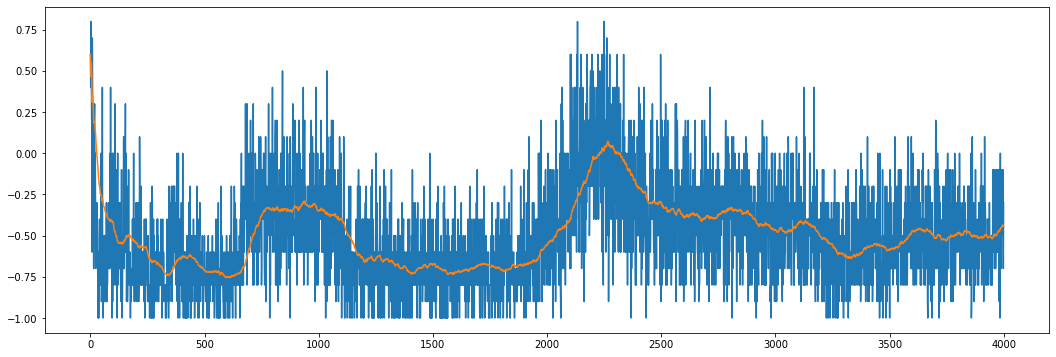

In [26]:
plot_metrics(final_validation_scores)

In [42]:
drl_agent.save_model('../checkpoints/model_final.pt')

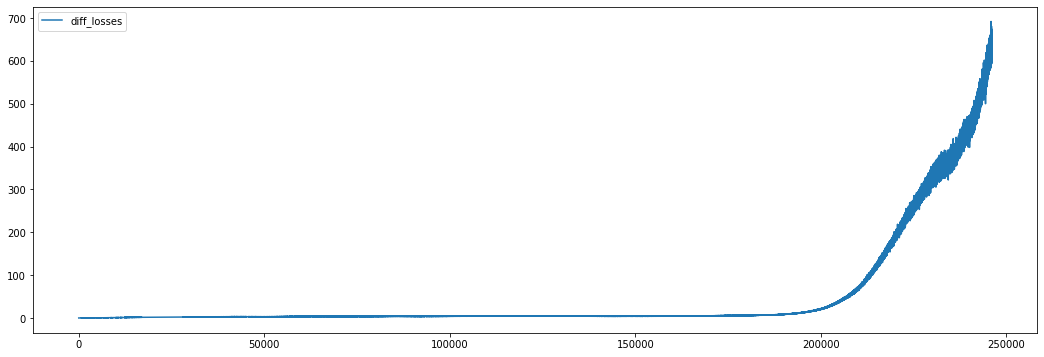

In [37]:
losses = drl_agent.get_losses()
fig, ax = plt.subplots(figsize=(18,6))
# ax.plot(losses['actor_losses'][:200000], label='actor_losses')
# ax.plot(losses['critic_losses'][:200000], label='critic_losses')
ax.plot(list((critic_loss - actor_loss) for critic_loss, actor_loss in zip(losses['critic_losses'][:], losses['actor_losses'][:])), label='diff_losses')
plt.legend(loc='best')
plt.show();

In [43]:
controller.reset_game()

Select one of the following players to be player 1
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
Input desired player number: 0
Select one of the following players to be player 2
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
Input desired player number: 1
                  1 | 2 | 3 
                 ---+---+---
                  4 | 5 | 6 
                 ---+---+---
                  7 | 8 | 9 
Player 1 (X): 100           Player 2 (O): 100

Player DRLPlayer(X) bidding...
Player HumanPlayer(O) bidding...
10
Player DRLPlayer(X) bid: 98  |  Player HumanPlayer(O) bid: 10  |  
Player DRLPlayer(X) won the bet
                  X | 2 | 3 
                 ---+---+---
                  4 | 5 | 6 
                 ---+---+---
                  7 | 8 | 9 
Player 1 (X):   2           Player 2 (O): 198

Player DRLPlayer(X) bidding...
Player HumanPlayer(O) bidding...
5
